# VR CO2 Study - Data processing

This notebook does the following:

1. x
2. y
3. z

Input: input
Output: output

In [5]:
# TODO
#1. Participant 1 CO2 mask data time is weird. First row of data in mask co2 df is '2022-04-27 17:50:59 UTC' while the file suggests it started 2022-04-27T19-55-22
#2 Participant 10 seems to have the same issue as P1 but generated fixed time csv. Still needs solving
#3 feature extraction for entire segments. If there are any peaks inside window (segment in this case) that include outlier, entire segment is NaN'ed

In [64]:
# Imports
import os
if('notebooks' in os.getcwd()):
    os.chdir('..')
import json
import pandas as pd
from utils.constants import AirFiles, CO2Files, DATA_COLUMNS, FREQUENCIES
from utils.load_data import load_data_with_event_matching
from utils.timestamps import read_unix, read_j2000, j2000_to_unix, generate_biopac_unix_timestamps
from classes.Participant import Participant
from classes.DataHandler import DataHandler
import numpy as np
import matplotlib.pyplot as plt
from utils.plots import Plots
from utils.normalisation import eye_tracking as normalise_pupil_size
import math


In [65]:
# Open file index JSON for reading
file_index = pd.read_json(os.path.join(os.getcwd(), 'temp/file_index.json'))
file_index = file_index.sort_index()
participant_ids = file_index.index
participant_ids

Int64Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
            17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
            34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
            51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62],
           dtype='int64')

In [66]:
#participant_ids = [23]
# good participants
#participant_ids = [1,2,7,9,10,11,12,13,14,15,16,17,18,19,20,22,23,24,25,26,27,28,29,32,33,34,35,36,37,38,43,44,45,46,47,48,49,51,52,53,54,55,57,59,60,61,62,63]
#participants i can actually run
participant_ids = [2,7,9,11,12,13,14,15,16,17,18,19,20,22,23,24,25,26,27,28,29,32,33,34,35,36,37,38,43,44,45,46,47,48,49,51,52,53,54,55,57,59,60,61,62,63]
#participant_ids = [33,34,35,36,37,38,43,44,45,46,47,48,49,51,52,53,54,55,57,59,60,61,62,63]
# panic, incomplete participants
#participants_ids_panic = [5,6,21,30,39,40,42,58]
participant_ids = [id - 1 for id in participant_ids]
synced_data_directory = os.path.join(os.getcwd(), 'temp', 'synced_participant_data')
len(participant_ids)

46

Generating new synced participant file for participant: 2_john
Loading Air condition Data
2022-04-30 12:08:31 UTC
Loading mask data for participant: 2_john
Finished mask loading data for participant: 2_john
Loading eye data for participant: 2_john
Imputed eye data file exists. Loading from temp/processed_eye_data
Finished loading eye data for participant: 2_john
Loading biopac data for participant: 2_john
Synchronising mask and eye tracking files.
Finished synchronising mask and eye tracking files
Synchronising mask and biopac files.
Finished synchronising mask and biopac files
Loading CO2 condition Data
Loading mask data for participant: 2_john
Finished mask loading data for participant: 2_john
Loading eye data for participant: 2_john
Imputed eye data file exists. Loading from temp/processed_eye_data
Finished loading eye data for participant: 2_john
Loading biopac data for participant: 2_john
Synchronising mask and eye tracking files.
Finished synchronising mask and eye tracking files

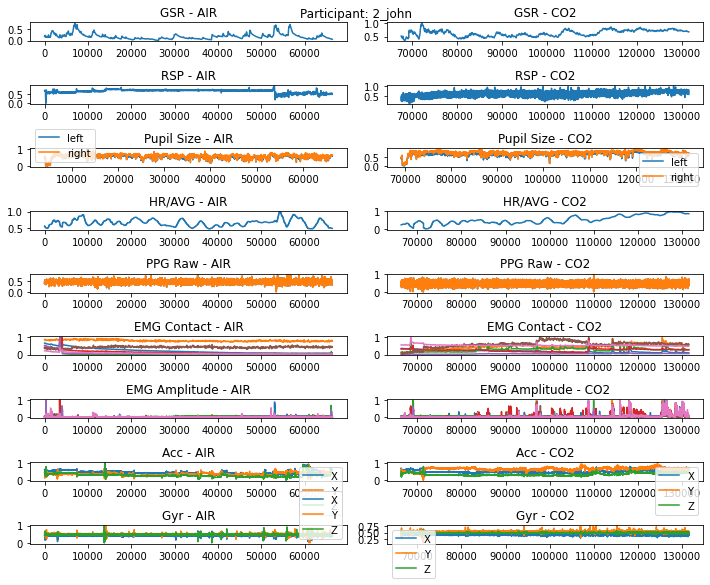

Features file found. Loading features file for participant: 2_john
Features file found. Loading features file for participant: 2_john
Finished data processing for participant: 2_john
Generating new synced participant file for participant: 7_aliaksei
Loading Air condition Data
2022-05-12 08:48:57 UTC
Loading mask data for participant: 7_aliaksei
Finished mask loading data for participant: 7_aliaksei
Loading eye data for participant: 7_aliaksei


C:\Users\Michal\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


Imputing eye tracking data
Finished loading eye data for participant: 7_aliaksei
Loading biopac data for participant: 7_aliaksei
Synchronising mask and eye tracking files.


KeyboardInterrupt: 

In [71]:
# Loop that generates downsampled, synced files for every participant
for participant_id in participant_ids:
    participant_to_retrieve = participant_id
    participant_file_index = file_index[0][participant_to_retrieve]
    participant = Participant(participant_file_index['id'])
    
    synced_participant_file = os.path.join(synced_data_directory, str(participant.id)) + '.csv'
    if(os.path.exists(synced_participant_file)):
        print('Synced file for participant: ' + str(participant.id) + ' found. Loading existing file.')
        participant.set_synced_data(pd.read_csv(synced_participant_file))
    else:
        print('Generating new synced participant file for participant: ' + str(participant.id))
        
        # AIR
        if(participant_file_index[AirFiles.MASK.value] is None):
            print('Air mask file missing')
        else:
            print('Loading Air condition Data')
            air_mask_file = participant_file_index[AirFiles.MASK.value]
            air_event_file = participant_file_index[AirFiles.EVENT.value]
            air_eyetracking_file = participant_file_index[AirFiles.EYE.value]
            air_biopac_file = participant_file_index[AirFiles.BIOPAC.value]
            air_biopac_start_unix = participant_file_index[AirFiles.BIOPAC_UNIX_START_TIME.value]
            print(read_unix(air_biopac_start_unix))

            # Load mask data
            participant.set_air_mask_data(DataHandler.load_mask_data(air_mask_file, air_event_file, participant.id))
            # Load eye tracking data
            participant.set_air_eye_data(DataHandler.load_eyetracking_data(air_eyetracking_file, participant.id, 'air'))  
            # Load biopac data
            participant.set_air_biopac_data(DataHandler.load_biopac_data(air_biopac_file, air_biopac_start_unix, participant.id))  
            # Sync eye tracking and biopac data
            participant.set_air_synced_data(DataHandler.sync_signal_data(participant.air_mask_data, participant.air_eye_data, participant.air_biopac_data, air_biopac_start_unix))

        #CO2
        print('Loading CO2 condition Data')
        co2_mask_file = participant_file_index[CO2Files.MASK.value]
        co2_event_file = participant_file_index[CO2Files.EVENT.value]
        co2_eyetracking_file = participant_file_index[CO2Files.EYE.value]
        co2_biopac_file = participant_file_index[CO2Files.BIOPAC.value]
        co2_biopac_start_unix = participant_file_index[CO2Files.BIOPAC_UNIX_START_TIME.value]

        # Load mask data
        participant.set_co2_mask_data(DataHandler.load_mask_data(co2_mask_file, co2_event_file, participant.id))
        # Load eye tracking data
        participant.set_co2_eye_data(DataHandler.load_eyetracking_data(co2_eyetracking_file, participant.id, 'co2'))  
        # Load biopac data
        participant.set_co2_biopac_data(DataHandler.load_biopac_data(co2_biopac_file, co2_biopac_start_unix, participant.id))  
        # Sync eye tracking and biopac data
        participant.set_co2_synced_data(DataHandler.sync_signal_data(participant.co2_mask_data, participant.co2_eye_data, participant.co2_biopac_data, co2_biopac_start_unix))
    
        print('Downsampling and combining data')
        #Downsample and combine data. This data is also saved
        participant.set_synced_data(DataHandler.downsample_participant_data(participant.id, DataHandler.label_data(participant.air_synced_data), DataHandler.label_data(participant.co2_synced_data)))
    
    # Filter data
    filtered_data = DataHandler.filter_data(participant.synced_data)
    # Normalise data per participant
    normalised_data = DataHandler.normalise_data(filtered_data)
    
    Plots.participant_overview(normalised_data, True)
    
    # Feature extraction
    windowed_features = DataHandler.extract_features(normalised_data)
    segment_features = DataHandler.extract_features_entire_condition(normalised_data)
    # ML
    print('Finished data processing for participant: ' + participant.id)



In [72]:
# Merge individual participant windowed feature files 
combined_features_windowed = DataHandler.merge_participant_windowed_feature_files()

In [73]:
# Merge individual participant segment feature files
combined_features_segments = DataHandler.merge_participant_segment_feature_files()

In [74]:
# Filter gas inhalation segments, detele any rows with any empty values and export to CSV for ML
gas_inhalation_df = combined_features_windowed[combined_features_windowed['Segment']=='gas_inhalation']
gas_inhalation_df.dropna(inplace=True)
gas_inhalation_df.to_csv(os.path.join(os.getcwd(), 'temp', 'gas_inhalation_df2.csv'), index=False)